In [1]:
#%matplotlib qt
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
#from image_slicer import slice
from skimage.io import imread, imshow

In [2]:
#s = hs.load("../data/raw_data/20220325 1529 SI HAADF 3.90 Mx.emd")
#s = hs.load("../data/raw_data/20220325 1058 SI HAADF 980 kx.emd")
#s = hs.load("../data/raw_data/20220325 1108 SI HAADF 2.75 Mx.emd")
#s = hs.load("../data/raw_data/20220325 1152 SI HAADF 5.50 Mx.emd")
s = hs.load("../data/raw_data/20220325 1205 SI HAADF 3.90 Mx.emd")

(600.0, 1000.0, 0.0, 5000.0)

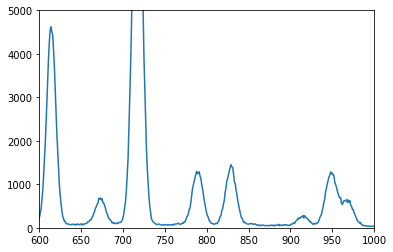

In [3]:
spectrum = s[0].data + s[1].data + s[2].data + s[3].data
plt.plot(spectrum)
plt.axis([600,1000,0,5000])

c:\Users\defo150\Anaconda3\envs\multimodal_env\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


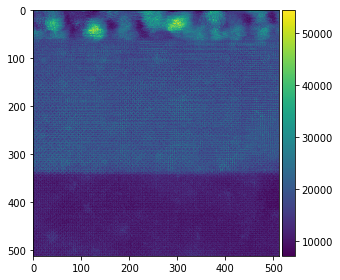

In [20]:
for i in range(len(s)):
    if s[i].metadata['General']['title'] == 'HAADF':
        haadf_img = s[i].data
        location = i
imshow(haadf_img)
s[location].save("Testing/multimodal1/img1", extension = 'jpg') 

## Preprocessing of TEM image data

X-ray spectrums associated with each pixel come from the X-ray map named as "navigator" in the raw data.

Create empty matrices that have the same size of each domain image.

In [21]:
pix_spec = s[-1].data

Iterate over each empty matrix to fill with the 1-d x-ray spectrum at tha pixel.

In [22]:
np.save('Testing/multimodal1/spectrum1', pix_spec)